In [11]:
# %%
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score

# Setup
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

MODELS = Path('../models')
REPORTS = Path('../reports')
DATA = Path('../data/processed')

REPORTS.mkdir(exist_ok=True, parents=True)

In [12]:
# ==========================================================
# 1. Load Models and Data
# ==========================================================
clf = joblib.load(MODELS / 'fertilizer_type_model.pkl')
reg = joblib.load(MODELS / 'fertilizer_quantity_model.pkl')

train = pd.read_csv(DATA / 'train.csv')
val = pd.read_csv(DATA / 'val.csv')
test = pd.read_csv(DATA / 'test.csv')

print(f"✅ Data Loaded — Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")

✅ Data Loaded — Train: (11987, 53), Val: (2116, 53), Test: (2489, 53)


In [13]:
# ==========================================================
# 2. Add Rule-Based Features (consistency with training)
# ==========================================================
def add_rule_features(df):
    """Add the same agronomic rule-based features used during training."""
    df = df.copy()
    df['High_N_Need'] = (df['Nitrogen_Level'] < 100).astype(int)
    df['High_P_Need'] = (df['Phosphorus_Level'] < 30).astype(int)
    df['High_K_Need'] = (df['Potassium_Level'] < 100).astype(int)
    return df

In [ ]:
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[15], line 38
     31     return df_encoded
     33 # Load your saved label encoders (if not already in memory)
     34 # import joblib
     35 # label_encoders = joblib.load("../models/label_encoders.pkl")
     36 
     37 # Apply encoders
---> 38 X_test_clf_encoded = apply_saved_encoders(X_test_clf, label_encoders)
     40 # ----------------------------------------------------------
     41 # 3️⃣ Predict
     42 # ----------------------------------------------------------
     43 preds_clf = clf.predict(X_test_clf_encoded)

NameError: name 'label_encoders' is not defined

NameError: name 'label_encoders' is not defined

📊 Classification Report:
               precision    recall  f1-score   support

     Compost       1.00      0.93      0.96      1567
         DAP       0.85      0.54      0.66       186
       Mixed       0.33      0.79      0.47       201
      Potash       0.68      0.57      0.62       244
        Urea       0.80      0.64      0.71       291

    accuracy                           0.82      2489
   macro avg       0.73      0.69      0.69      2489
weighted avg       0.88      0.82      0.84      2489



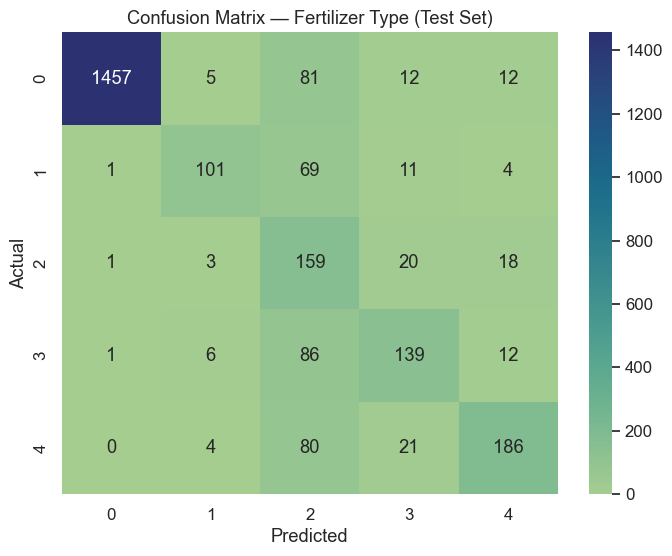

✅ Classification Evaluation Complete!


In [16]:
# ==========================================================
# 3. Classification Evaluation (Fixed for Text Columns)
# ==========================================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

# ----------------------------------------------------------
# 1️⃣ Prepare test data
# ----------------------------------------------------------
X_test_clf = test.drop(['Fertilizer_Type', 'Recommended_Quantity_kg_per_acre'], axis=1)
y_test_clf = test['Fertilizer_Type']

# Add same engineered features used during training
X_test_clf = add_rule_features(X_test_clf)

# ----------------------------------------------------------
# 2️⃣ Load saved encoders and encode categorical columns
# ----------------------------------------------------------
MODELS = Path("../models")  # Adjust if your folder structure is different
label_encoders = joblib.load(MODELS / "label_encoders.pkl")

def apply_saved_encoders(df, encoders):
    df_encoded = df.copy()
    for col, le in encoders.items():
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].astype(str)
            known_classes = set(le.classes_)
            # Handle unseen labels gracefully
            df_encoded[col] = df_encoded[col].apply(
                lambda x: x if x in known_classes else list(known_classes)[0]
            )
            df_encoded[col] = le.transform(df_encoded[col])
    return df_encoded

# ✅ Apply encoders
X_test_clf_encoded = apply_saved_encoders(X_test_clf, label_encoders)

# ----------------------------------------------------------
# 3️⃣ Predict
# ----------------------------------------------------------
preds_clf = clf.predict(X_test_clf_encoded)

# ----------------------------------------------------------
# 4️⃣ Evaluation
# ----------------------------------------------------------
print("📊 Classification Report:\n", classification_report(y_test_clf, preds_clf))

# Confusion matrix
cm = confusion_matrix(y_test_clf, preds_clf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
plt.title("Confusion Matrix — Fertilizer Type (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("✅ Classification Evaluation Complete!")


✅ Regression Evaluation Complete
Mean Absolute Error (MAE): 13.37
R² Score: 0.124


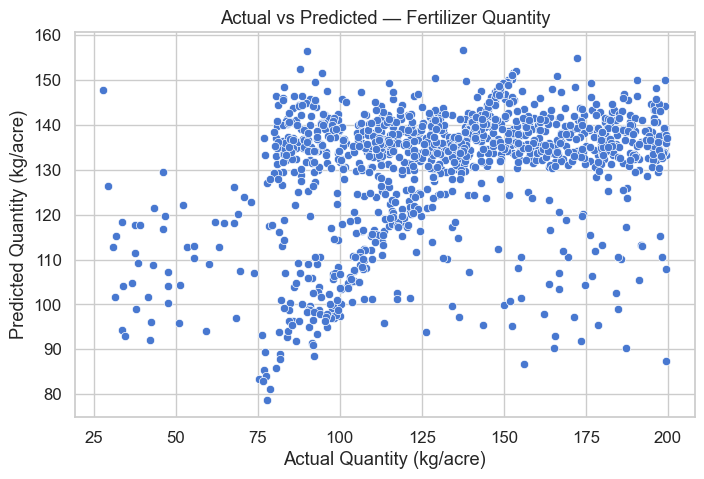

In [18]:
# ==========================================================
# 4. Regression Evaluation (Fixed for Text Columns)
# ==========================================================
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

# ----------------------------------------------------------
# 1️⃣ Prepare test data
# ----------------------------------------------------------
X_test_reg = X_test_clf.copy()
y_test_reg = test['Recommended_Quantity_kg_per_acre']

# ----------------------------------------------------------
# 2️⃣ Load saved label encoders
# ----------------------------------------------------------
MODELS = Path("../models")
label_encoders = joblib.load(MODELS / "label_encoders.pkl")

# ----------------------------------------------------------
# 3️⃣ Apply encoders to categorical columns
# ----------------------------------------------------------
def apply_saved_encoders(df, encoders):
    df_encoded = df.copy()
    for col, le in encoders.items():
        if col in df_encoded.columns:
            df_encoded[col] = df_encoded[col].astype(str)
            known_classes = set(le.classes_)
            # Handle unseen labels gracefully
            df_encoded[col] = df_encoded[col].apply(
                lambda x: x if x in known_classes else list(known_classes)[0]
            )
            df_encoded[col] = le.transform(df_encoded[col])
    return df_encoded

X_test_reg_encoded = apply_saved_encoders(X_test_reg, label_encoders)

# ----------------------------------------------------------
# 4️⃣ Align features with model training order
# ----------------------------------------------------------
import numpy as np

# This ensures columns are in the same order your model expects
if hasattr(reg, "feature_names_in_"):
    for col in reg.feature_names_in_:
        if col not in X_test_reg_encoded.columns:
            X_test_reg_encoded[col] = 0
    X_test_reg_encoded = X_test_reg_encoded[reg.feature_names_in_]
else:
    # Optional fallback
    print("⚠️ Warning: reg.feature_names_in_ not found; using current column order.")

# ----------------------------------------------------------
# 5️⃣ Predict
# ----------------------------------------------------------
preds_reg = reg.predict(X_test_reg_encoded)

# ----------------------------------------------------------
# 6️⃣ Evaluate
# ----------------------------------------------------------
mae = mean_absolute_error(y_test_reg, preds_reg)
r2 = r2_score(y_test_reg, preds_reg)

print(f"✅ Regression Evaluation Complete")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.3f}")

# ----------------------------------------------------------
# 7️⃣ Plot Actual vs Predicted
# ----------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_reg, y=preds_reg)
plt.title('Actual vs Predicted — Fertilizer Quantity')
plt.xlabel('Actual Quantity (kg/acre)')
plt.ylabel('Predicted Quantity (kg/acre)')
plt.show()


In [19]:
# ==========================================================
# 5. Save Evaluation Report
# ==========================================================
report = {
    'Classification_Accuracy': round((preds_clf == y_test_clf).mean(), 4),
    'Regression_MAE': round(mae, 4),
    'Regression_R2': round(r2, 4)
}
report_df = pd.DataFrame([report])
report_path = REPORTS / 'final_evaluation.csv'
report_df.to_csv(report_path, index=False)
print(f"✅ Final evaluation metrics saved to: {report_path.resolve()}")
display(report_df)

✅ Final evaluation metrics saved to: C:\Users\sasik\OneDrive\Desktop\AIML Project\reports\final_evaluation.csv


,Classification_Accuracy,Regression_MAE,Regression_R2
0,0.8204,13.3651,0.1237


In [20]:
# ==========================================================
# 6. Model Card Generation
# ==========================================================
model_card = f"""
# 🌾 Smart Fertilizer Recommender — Model Card

**Generated:** Automatically  
**Version:** 1.0  

**Models Used:**
- RandomForestClassifier — Fertilizer Type  
- RandomForestRegressor — Recommended Quantity  

**Performance:**
- Accuracy: {report['Classification_Accuracy']:.2f}  
- MAE: {report['Regression_MAE']:.2f}  
- R²: {report['Regression_R2']:.2f}  

**Data Summary:**
- ~{len(train) + len(val) + len(test)} samples  
- 15 input features (Crop type, Region, Soil properties, Weather, etc.)

**Purpose:**
To recommend the optimal fertilizer type and quantity per acre based on soil nutrients, crop type, and climate.

**Limitations:**
- May not generalize perfectly to new soil types or extreme weather.  
- Retrain yearly with updated data for local calibration.  

**Ethical Note:**
Model designed for assisting, not replacing, agricultural expertise.
"""

with open(REPORTS / 'model_card.md', 'w', encoding='utf-8') as f:
    f.write(model_card)

print("✅ Model Card saved at reports/model_card.md")

✅ Model Card saved at reports/model_card.md


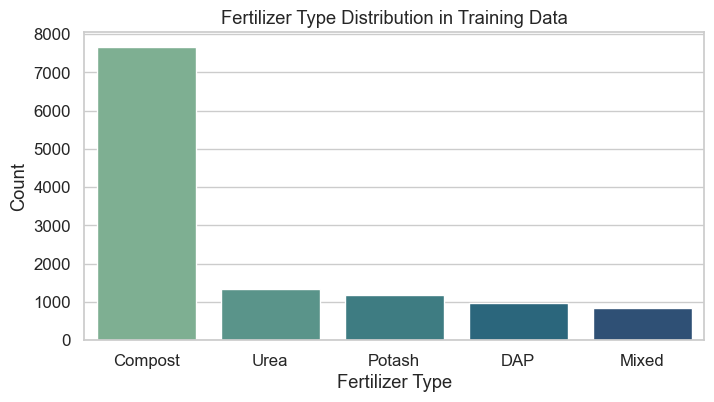

✅ Visualization complete and evaluation successful!


In [9]:
# ==========================================================
# 7. Visualization — Class Distribution
# ==========================================================
plt.figure(figsize=(8, 4))
sns.barplot(
    x=train['Fertilizer_Type'].value_counts().index,
    y=train['Fertilizer_Type'].value_counts().values,
    hue=train['Fertilizer_Type'].value_counts().index,
    legend=False,
    palette='crest'
)
plt.title('Fertilizer Type Distribution in Training Data')
plt.ylabel('Count')
plt.xlabel('Fertilizer Type')
plt.show()

print("✅ Visualization complete and evaluation successful!")

In [10]:
# ==========================================================
# 8. Compact Summary Table
# ==========================================================
from tabulate import tabulate

summary_df = pd.DataFrame([{
    "Classification_Accuracy": report["Classification_Accuracy"],
    "Regression_MAE": report["Regression_MAE"],
    "Regression_R2": report["Regression_R2"]
}])

print("\n📋 Model Performance Summary:")
print(tabulate(summary_df, headers='keys', tablefmt='github', showindex=False))


📋 Model Performance Summary:
|   Classification_Accuracy |   Regression_MAE |   Regression_R2 |
|---------------------------|------------------|-----------------|
|                    0.8204 |          13.3651 |          0.1237 |
